In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/catfitmodel/catfit
/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
import catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

In [4]:
numeric_columns=df_train.select_dtypes(include=np.number).columns
numeric_columns

Index(['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Premium Amount'],
      dtype='object')

In [5]:
df_train['Health Score'].max()

58.97591405405534

In [6]:
Ana=df_train['Age'].mean()
Aina=df_train['Annual Income'].mean()
Ndna=0
Hsna=df_train['Health Score'].mean()
Pcna=0
Vana=0 #just impute with 0
Csna=df_train['Credit Score'].mean()
Idna=0

In [7]:
#Check Na credit score and premium amount
# There a lot of missing score with a lot of premium no different with having creditscor
df_train[df_train['Credit Score'].notna()].groupby('Premium Amount').size().reset_index(name='count').assign(total=lambda x:x['Premium Amount']*x['count']).groupby('count')['total'].sum()

count
1        720797.0
2       1155398.0
3       1264602.0
4       1489848.0
5       2094605.0
          ...    
3009      84252.0
3122      71806.0
3396      67920.0
3444      82656.0
3735      93375.0
Name: total, Length: 917, dtype: float64

In [8]:
25*533

13325

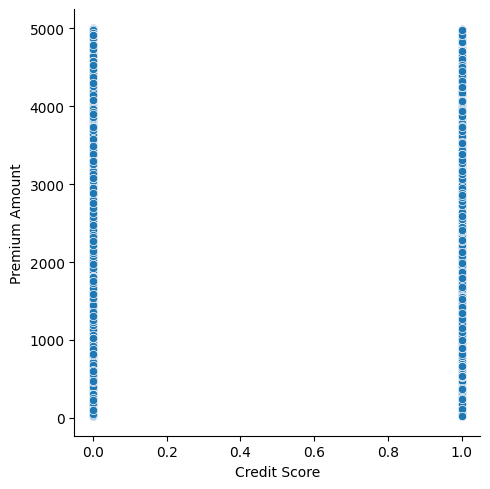

In [9]:
#Exploratory relation with missing Age and Premium
df_train['group Age']=df_train['Age'].notna().replace({True: 'Age Not NaN', False: 'Age NaN'})

#sns.relplot(data=df_train,x='Age',y='Premium Amount',hue='group Age',hue_order=['Age Not NaN','Age NaN'],palette={'Age Not NaN':'gray','Age NaN':'red'},kind='scatter')
sns.relplot(x=df_train['Credit Score'].isna(),y=df_train['Premium Amount'],kind='scatter')
plt.show()

#sns.pairplot(data=df_train, vars=['Credit Score', 'Health Score', 'Premium Amount'], hue='Premium Amount', palette='coolwarm')
#plt.show()


In [10]:
df_train['Age'].fillna(Ana,inplace=True)
df_train['Annual Income'].fillna(Aina,inplace=True)
df_train['Number of Dependents'].fillna(Ndna,inplace=True)
df_train['Health Score'].fillna(Hsna,inplace=True)
df_train['Previous Claims'].fillna(Pcna,inplace=True)
df_train['Vehicle Age'].fillna(Vana,inplace=True)
df_train['Credit Score'].fillna(Csna,inplace=True)
df_train['Insurance Duration'].fillna(Idna,inplace=True)


#Ana=df_test['Age'].mean()
#Aina=df_test['Annual Income'].mean()
#Ndna=0
#Hsna=df_test['Health Score'].mean()
#Pcna=0
#Vana=0 #just impute with 0
#Csna=df_test['Credit Score'].mean()
#Idna=0

df_test['Age'].fillna(Ana,inplace=True)
df_test['Annual Income'].fillna(Aina,inplace=True)
df_test['Number of Dependents'].fillna(Ndna,inplace=True)
df_test['Health Score'].fillna(Hsna,inplace=True)
df_test['Previous Claims'].fillna(Pcna,inplace=True)
df_test['Vehicle Age'].fillna(Vana,inplace=True)
df_test['Credit Score'].fillna(Csna,inplace=True)
df_test['Insurance Duration'].fillna(Idna,inplace=True)



/tmp/ipykernel_24/3042408332.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(Ana,inplace=True)
/tmp/ipykernel_24/3042408332.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [11]:
object_columns=df_train.select_dtypes(include=object).columns
object_columns

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type', 'group Age'],
      dtype='object')

In [12]:
df_test.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')

In [13]:
df_train['Occupation'].fillna('Unknown',inplace=True)
df_train['Marital Status'].fillna('Unknown',inplace=True)
df_train['Customer Feedback'].fillna('Unknown',inplace=True)

df_test['Occupation'].fillna('Unknown',inplace=True)
df_test['Marital Status'].fillna('Unknown',inplace=True)
df_test['Customer Feedback'].fillna('Unknown',inplace=True)


/tmp/ipykernel_24/1312047004.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Occupation'].fillna('Unknown',inplace=True)
/tmp/ipykernel_24/1312047004.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [14]:
cat_features=numeric_columns.drop(['id','Age','Annual Income','Credit Score','Health Score','Premium Amount']).union(object_columns.drop(['group Age']))
cat_features.to_list()


['Customer Feedback',
 'Education Level',
 'Exercise Frequency',
 'Gender',
 'Insurance Duration',
 'Location',
 'Marital Status',
 'Number of Dependents',
 'Occupation',
 'Policy Start Date',
 'Policy Type',
 'Previous Claims',
 'Property Type',
 'Smoking Status',
 'Vehicle Age']

In [15]:
#change cat columns datatype to astype int
df_train[cat_features.intersection(numeric_columns)]=df_train[cat_features.intersection(numeric_columns)].astype(int)

#text_features = cat_features.remove('Vehicle Age')

In [16]:
#change cat columns datatype to int astype
df_test[cat_features.intersection(numeric_columns)]=df_test[cat_features.intersection(numeric_columns)].astype(int)

#text_features = cat_features.remove('Vehicle Age')

In [17]:
text_features = cat_features.difference(numeric_columns)
text_features

Index(['Customer Feedback', 'Education Level', 'Exercise Frequency', 'Gender',
       'Location', 'Marital Status', 'Occupation', 'Policy Start Date',
       'Policy Type', 'Property Type', 'Smoking Status'],
      dtype='object')

In [18]:
df_train.isna().any()

id                      False
Age                     False
Gender                  False
Annual Income           False
Marital Status          False
Number of Dependents    False
Education Level         False
Occupation              False
Health Score            False
Location                False
Policy Type             False
Previous Claims         False
Vehicle Age             False
Credit Score            False
Insurance Duration      False
Policy Start Date       False
Customer Feedback       False
Smoking Status          False
Exercise Frequency      False
Property Type           False
Premium Amount          False
group Age               False
dtype: bool

In [19]:
#custom loss function but will not be able to optimization with it so better transform target instead
def rmsle_loss(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))
#Also use exp to transform the prediction
#predictions = np.expm1(model.predict(X_test))

In [20]:
#transform target
df_train['Label']=np.log1p(df_train['Premium Amount'])


In [21]:
df_train['Label'].describe()

count    1.200000e+06
mean     6.593889e+00
std      1.095825e+00
min      3.044522e+00
25%      6.244167e+00
50%      6.771936e+00
75%      7.319865e+00
max      8.517193e+00
Name: Label, dtype: float64

In [22]:
df_train.drop(['id','Annual Income','Customer Feedback','Exercise Frequency','Premium Amount','group Age','Label'],axis=1).columns

Index(['Age', 'Gender', 'Marital Status', 'Number of Dependents',
       'Education Level', 'Occupation', 'Health Score', 'Location',
       'Policy Type', 'Previous Claims', 'Vehicle Age', 'Credit Score',
       'Insurance Duration', 'Policy Start Date', 'Smoking Status',
       'Property Type'],
      dtype='object')

In [23]:
df_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'group Age', 'Label'],
      dtype='object')

In [24]:
df_train2 = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
df_train2=df_train2.dropna()


In [25]:
nonadata = pd.concat([df_train2['Credit Score'],df_train2['Health Score']],axis=1)
nonadata.head()

,Credit Score,Health Score
0,372.0,22.598761
4,598.0,20.376094
7,398.0,5.769783
9,635.0,20.473718
15,584.0,7.442964


In [26]:
nonadata.describe()
from sklearn.preprocessing import StandardScaler, RobustScaler

#standard_scaler=StandardScaler()
#scalenonadata=standard_scaler.fit_transform(nonadata)

robust_scaler=RobustScaler()
scalenonadata=robust_scaler.fit_transform(nonadata)

In [27]:
nonadata=pd.DataFrame(scalenonadata,columns=['Credit Score','Health Score'])

In [28]:
df_train2['Label'] = np.log1p(df_train2['Premium Amount'])

In [29]:
data = df_train.drop(['id','Premium Amount','group Age','Label'],axis=1) 
cat_features=cat_features.intersection(data.columns)
text_features=text_features.intersection(data.columns)

In [30]:
data = nonadata
label2 = df_train2['Label'].reset_index(drop=True)

In [31]:
df_train2['Insurance Duration'].unique()

array([5., 4., 3., 8., 2., 6., 7., 1., 9.])

In [70]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from catboost import CatBoostRegressor, Pool
from catboost.datasets import msrank

param = {
    'learning_rate': [0.03],
    'depth':[8, 10, 12],
    'l2_leaf_reg': [10,12],
    'iterations':[3000,8000]
}

bestparam = {
    'learning_rate': 0.03,
    'depth':8,
    'l2_leaf_reg':10,
    'iterations':3000,
    'early_stopping_rounds':200,
    'eval_metric':'RMSE',
    'save_snapshot':True,
    'snapshot_file':'catregsnap',
    'snapshot_interval':600,
    'verbose':300,
    'text_features':text_features.to_list(),
   # 'occurrence_lower_bound':1,
    
}

data = df_train.drop(['id','Premium Amount','group Age','Label'],axis=1) 
label=df_train['Label']

X_train,x_val,Y_train,y_val = train_test_split(data,label,test_size=0.3,random_state=11)

train_data = Pool(data=X_train,
                  label=Y_train,
                  cat_features=cat_features.to_list(),
                  text_features=text_features.to_list(),
                  #text_feature_params={'occurence_lower_bound':1}
                  )

eval_data =  Pool(data=x_val,
                  label=y_val,
                  cat_features=cat_features.to_list(),
                  text_features=text_features.to_list(),)

model = CatBoostRegressor(dictionaries=[{'dictionary_id':'Unigram','occurence_lower_bound':'1'},{'dictionary_id':'BiGram','gram_count':'2'},{'dictionary_id':'Word','occurence_lower_bound':'1'}])
model.set_params(**bestparam)
model.fit(X=train_data,eval_set=eval_data,use_best_model=True)
#grid_results = model.grid_search(param,train_data,cv=2,shuffle=False,stratified=True)



0:	learn: 1.0942303	test: 1.0943525	best: 1.0943525 (0)	total: 2.05s	remaining: 1h 42m 24s
300:	learn: 1.0516571	test: 1.0516858	best: 1.0516858 (300)	total: 9m 9s	remaining: 1h 22m 9s
600:	learn: 1.0494619	test: 1.0502296	best: 1.0502296 (600)	total: 17m 25s	remaining: 1h 9m 32s
900:	learn: 1.0476879	test: 1.0496725	best: 1.0496725 (900)	total: 26m 12s	remaining: 1h 1m 4s
1200:	learn: 1.0462454	test: 1.0494662	best: 1.0494662 (1200)	total: 34m 51s	remaining: 52m 13s
1500:	learn: 1.0450972	test: 1.0493551	best: 1.0493551 (1500)	total: 43m 3s	remaining: 43m
1800:	learn: 1.0439268	test: 1.0492579	best: 1.0492579 (1800)	total: 51m 31s	remaining: 34m 18s
2100:	learn: 1.0428611	test: 1.0492110	best: 1.0492102 (2096)	total: 59m 53s	remaining: 25m 37s
2400:	learn: 1.0417995	test: 1.0491887	best: 1.0491835 (2378)	total: 1h 8m 14s	remaining: 17m 1s
2700:	learn: 1.0407896	test: 1.0491735	best: 1.0491707 (2684)	total: 1h 16m 31s	remaining: 8m 28s
2999:	learn: 1.0397569	test: 1.0491585	best: 1.049

In [71]:
model.save_model('catfit')

In [33]:
from catboost import CatBoostRegressor,Pool

model=CatBoostRegressor()
model.load_model('/kaggle/input/catfitmodel/catfit')

In [70]:
data.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,19.0,Female,10049.0,Married,1,Bachelor's,Self-Employed,22.598761,Urban,Premium,2,17,372.00000,5,2023-12-23 15:21:39.134960,Poor,No,Weekly,House
1,39.0,Female,31678.0,Divorced,3,Master's,Unknown,15.569731,Rural,Comprehensive,1,12,694.00000,2,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House
2,23.0,Male,25602.0,Divorced,3,High School,Self-Employed,47.177549,Suburban,Premium,1,14,592.92435,3,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House
3,21.0,Male,141855.0,Married,2,Bachelor's,Unknown,10.938144,Rural,Basic,1,0,367.00000,1,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment
4,21.0,Male,39651.0,Single,1,Bachelor's,Self-Employed,20.376094,Rural,Premium,0,8,598.00000,4,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House


In [50]:
df_test.isna().any()

id                      False
Age                     False
Gender                  False
Annual Income           False
Marital Status          False
Number of Dependents    False
Education Level         False
Occupation              False
Health Score            False
Location                False
Policy Type             False
Previous Claims         False
Vehicle Age             False
Credit Score            False
Insurance Duration      False
Policy Start Date       False
Customer Feedback       False
Smoking Status          False
Exercise Frequency      False
Property Type           False
dtype: bool

In [52]:
#Trying Keras but it also produce 1.0+ sth 

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

# Assuming `X` (features) and `y` (log1p transformed target) are defined
X_train, X_val, y_train, y_val = train_test_split(nonadata, label2, test_size=0.2, random_state=42)

# Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Training the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                    ])

# Evaluate the model
loss, rmse = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation RMSE: {rmse}")

# Predicting and transforming the target back
y_pred = model.predict(X_val)
y_pred_original_scale = np.expm1(y_pred)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9601/9601 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 5.1985 - root_mean_squared_error: 2.1012 - val_loss: 1.2091 - val_root_mean_squared_error: 1.0996
Epoch 2/100
9601/9601 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1.3017 - root_mean_squared_error: 1.1409 - val_loss: 1.2021 - val_root_mean_squared_error: 1.0964
Epoch 3/100
9601/9601 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1.2725 - root_mean_squared_error: 1.1281 - val_loss: 1.1988 - val_root_mean_squared_error: 1.0949
Epoch 4/100
9601/9601 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1.2444 - root_mean_squared_error: 1.1155 - val_loss: 1.1989 - val_root_mean_squared_error: 1.0950
Epoch 5/100
9601/9601 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 1.2296 - root_mean_squared_error: 1.1089 - val_loss: 1.2067 - val_root_mean_squared_error: 1.0985
Epoch 6/100
9601/9601 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1.2221 - root_mean_squared_error: 1.1055 - val_loss: 1.1993 - val_root_mean_squared_error: 1.0951
Epoch 7/100
9601/9601 ━━━━━━━━━━━━━━━━━━

In [34]:
test=df_test.drop(['id'],axis=1)
test.columns
#predicts = model.predict(df_test.drop('id',axis=1))

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')

In [53]:
df_train.drop(['id','Premium Amount','group Age','Label'],axis=1).columns

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type'],
      dtype='object')

In [56]:
from sklearn.model_selection import train_test_split

data = df_train.drop(['id','Premium Amount','group Age','Label'],axis=1) 
label=df_train['Label']

X_train,x_val,Y_train,y_val = train_test_split(data,label,test_size=0.3,random_state=11)

predicts = model.predict(x_val)

In [35]:
test.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,28.0,Female,2310.0,Unknown,4,Bachelor's,Self-Employed,7.657981,Rural,Basic,0,19,592.92435,1,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,31.0,Female,126031.0,Married,2,Master's,Self-Employed,13.381379,Suburban,Premium,0,14,372.00000,8,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,47.0,Female,17092.0,Divorced,0,PhD,Unemployed,24.354527,Urban,Comprehensive,0,16,819.00000,9,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,28.0,Female,30424.0,Divorced,3,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1,3,770.00000,5,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,24.0,Male,10863.0,Divorced,2,High School,Unemployed,11.844155,Suburban,Premium,0,14,755.00000,7,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [60]:
x_val.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
879251,63.0,Male,7053.0,Married,2,PhD,Unemployed,16.293723,Urban,Comprehensive,0,18,563.00000,3,2022-04-23 15:21:39.146733,Average,No,Rarely,Condo
840987,27.0,Male,23879.0,Single,3,Master's,Unknown,25.896797,Rural,Comprehensive,1,16,721.00000,1,2023-03-10 15:21:39.113566,Good,No,Daily,Apartment
689444,35.0,Male,65506.0,Single,3,High School,Self-Employed,17.953989,Rural,Premium,2,5,592.92435,4,2024-06-14 15:21:39.120168,Good,Yes,Monthly,Condo
951696,24.0,Male,27963.0,Divorced,2,PhD,Self-Employed,10.917782,Suburban,Basic,3,1,515.00000,7,2021-05-06 15:21:39.274993,Good,Yes,Monthly,House
768963,21.0,Male,44311.0,Married,0,PhD,Unknown,28.593691,Suburban,Comprehensive,2,13,652.00000,2,2019-12-07 15:21:39.237118,Good,Yes,Weekly,Apartment


In [64]:
cat_features.to_list()

['Customer Feedback',
 'Education Level',
 'Exercise Frequency',
 'Gender',
 'Insurance Duration',
 'Location',
 'Marital Status',
 'Number of Dependents',
 'Occupation',
 'Policy Start Date',
 'Policy Type',
 'Previous Claims',
 'Property Type',
 'Smoking Status',
 'Vehicle Age']

In [ ]:
grid_results['params']

In [ ]:
grid_results['cv_results']['train-RMSE-mean']

In [36]:
predicts = model.predict(test)

In [38]:
predicts_original_scale = np.expm1(predicts)

In [49]:
temp=pd.concat([df_test['id'],pd.DataFrame(np.rint(predicts_original_scale),columns=['Premium Amount'])],axis=1).reset_index(drop=True)

In [51]:
temp2=pd.concat([df_test['id'],pd.DataFrame(predicts_original_scale.astype(int),columns=['Premium Amount'])],axis=1).reset_index(drop=True)

In [52]:
temp2.to_csv('submission.csv',index=False)